
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)

In [6]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

你需要让我选一段吴承恩的西游记然后我改写的风格类似于水浒传（明朝）的话题。

假设我选了一段是“孙悟空大战白骨精”，下面是我改写后的版本：

### 宋江在金山探险：金身变幻术

金沙滩上，一尊美丽的仙女般的女子出现在宋江面前。她的面容清丽，举止优雅，如同天上的仙女。她告诉宋江，她就是水浒山中一个修道者的爱侣，是在这里等待着他。

"我与我的丈夫是夫妻一体，但因为他遭受了恶人们的毒害，我只得独自来金沙滩，等待他的归来。我听说您是一个有大智慧的大侠，你能将我的丈夫带回这里，让我们一起团聚?"

### 宋江的智慧之计

宋江看到她的悲伤和求救，他知道这位仙女是被白骨精迷惑了的心灵。于是，宋江施展他敏锐的思维，用一种轻松的口吻问道：

"好仙女，您为什么会在这里守候？难道您丈夫被困在这里，不得自由吗？如果您愿意，我可以带路，去找您的丈夫，为您夫妇重圆。如果不然，也不是问题，但我要告诉您，白骨精并没有让您的丈夫留在那里，而是他自己选择离开的。您知道为什么?"

### 白骨精出世：妖力的显现

金沙滩上忽然传来巨响，一阵阴风袭过山谷，那个仙女的容颜逐渐变成黑如煤炭，双眼变得如同铜锅烫熟后的赤红色。一个声音从她的口中发出：

"我是白骨精，你这个无知的凡夫，想要干涉我的事，你还不知道我什么是妖力？看我一现罡风烈火，一举手百万兵马，一步迈进百年山河，你要是敢动一步，我就让你遭受一场地狱般的煎熬!"

### 宋江出其不意：妙计成败

宋江看到白骨精这副恐怖的模样，他没有表现出一点害怕，只是轻松地说：

"噢，这个女魔怪的能力果然厉害，看来她比一般的山野老妖强多了。好吧，我愿意与您较量一番，争气看看谁更高明。但是，您不必惊惧，我的智慧在这里等待着她的发挥。如果我赢了，您将帮助您的爱人回家；但如果您让我失败，那么您应该给予承诺，不再迷惑好人。"

### 结局：智者之过胜

"好呀，我答应您。"白骨精说完，这个仙女变回她的本来面容，说:"这是真的吗？我愿与您打斗一番，倾尽全身的妖力向您发射。但是，请告诉我，您将如何战胜我的?"

### 后记：友谊无言

宋江大笑道：“好，我答应您的。”于是他们进行了一场激烈的搏斗。虽然白骨精出于她的力量，威胁着整个山谷，但宋江凭着他的智慧，一一破解了她的各种恶毒陷阱，最终取得胜利。在得到承诺后，宋江带她前往寻找她的爱人。

这个改写后的版本，以

In [7]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

你需要让我选一段吴承恩的西游记然后我改写的风格类似于水浒传（明朝）的话题。

假设我选了一段是“孙悟空大战白骨精”，下面是我改写后的版本：

### 宋江在金山探险：金身变幻术

金沙滩上，一尊美丽的仙女般的女子出现在宋江面前。她的面容清丽，举止优雅，如同天上的仙女。她告诉宋江，她就是水浒山中一个修道者的爱侣，是在这里等待着他。

"我与我的丈夫是夫妻一体，但因为他遭受了恶人们的毒害，我只得独自来金沙滩，等待他的归来。我听说您是一个有大智慧的大侠，你能将我的丈夫带回这里，让我们一起团聚?"

### 宋江的智慧之计

宋江看到她的悲伤和求救，他知道这位仙女是被白骨精迷惑了的心灵。于是，宋江施展他敏锐的思维，用一种轻松的口吻问道：

"好仙女，您为什么会在这里守候？难道您丈夫被困在这里，不得自由吗？如果您愿意，我可以带路，去找您的丈夫，为您夫妇重圆。如果不然，也不是问题，但我要告诉您，白骨精并没有让您的丈夫留在那里，而是他自己选择离开的。您知道为什么?"

### 白骨精出世：妖力的显现

金沙滩上忽然传来巨响，一阵阴风袭过山谷，那个仙女的容颜逐渐变成黑如煤炭，双眼变得如同铜锅烫熟后的赤红色。一个声音从她的口中发出：

"我是白骨精，你这个无知的凡夫，想要干涉我的事，你还不知道我什么是妖力？看我一现罡风烈火，一举手百万兵马，一步迈进百年山河，你要是敢动一步，我就让你遭受一场地狱般的煎熬!"

### 宋江出其不意：妙计成败

宋江看到白骨精这副恐怖的模样，他没有表现出一点害怕，只是轻松地说：

"噢，这个女魔怪的能力果然厉害，看来她比一般的山野老妖强多了。好吧，我愿意与您较量一番，争气看看谁更高明。但是，您不必惊惧，我的智慧在这里等待着她的发挥。如果我赢了，您将帮助您的爱人回家；但如果您让我失败，那么您应该给予承诺，不再迷惑好人。"

### 结局：智者之过胜

"好呀，我答应您。"白骨精说完，这个仙女变回她的本来面容，说:"这是真的吗？我愿与您打斗一番，倾尽全身的妖力向您发射。但是，请告诉我，您将如何战胜我的?"

### 后记：友谊无言

宋江大笑道：“好，我答应您的。”于是他们进行了一场激烈的搏斗。虽然白骨精出于她的力量，威胁着整个山谷，但宋江凭着他的智慧，一一破解了她的各种恶毒陷阱，最终取得胜利。在得到承诺后，宋江带她前往寻找她的爱人。

这个改写后的版本，以水浒传的风格，将吴承恩的西游记中关于白骨精的一段篇幅改写成更加活泼、生动，并富有情感味道的描述。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [8]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)

In [9]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

你的改写版本很好，但仍然需要一些调整来更好地体现水浒传的风格和特点。以下是我的建议：

**长度**: 水浒传的篇幅通常较长，平均每个故事大约有 10-15 个节。你的改写版本应该增加到至少 5-7 节，以便更好地展现宋江与白骨精之间的斗智和情感。

**人物性格**: 水浒传中的角色往往具有鲜明的个性和特点。你的改写版本中，宋江的智慧和幽默感很好，但白骨精的性格需要更多发展。她应该表现出更强烈的情绪波动和复杂的人物心理。

**情节**: 水浒传中的故事通常具有明显的起承转合结构。你的改写版本中，情节有些跳跃，不太清楚白骨精为什么会迷惑仙女，也没有很好地展现宋江与白骨精之间的斗智过程。

**语言风格**: 水浒传的语言风格通常较为生动、形象和俏皮。你的改写版本中，语言风格还需要进一步提高，以便更好地体现水浒传的特点。

具体来说，你可以尝试以下几点：

1. 增加情节的起承转合结构，使得故事更加流畅和逻辑。
2. 发展白骨精的性格，表现出她的复杂的人物心理和强烈的情绪波动。
3. 提高语言风格，使用更多的俚语、谚语和形象比喻，以便更好地体现水浒传的特点。
4. 增加对宋江与白骨精之间斗智过程的描述，使得故事更加生动和有趣。

总之，你的改写版本很好，但仍然需要进一步调整和完善，以便更好地体现水浒传的风格和特点。

In [10]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

你的改写版本很好，但仍然需要一些调整来更好地体现水浒传的风格和特点。以下是我的建议：

**长度**: 水浒传的篇幅通常较长，平均每个故事大约有 10-15 个节。你的改写版本应该增加到至少 5-7 节，以便更好地展现宋江与白骨精之间的斗智和情感。

**人物性格**: 水浒传中的角色往往具有鲜明的个性和特点。你的改写版本中，宋江的智慧和幽默感很好，但白骨精的性格需要更多发展。她应该表现出更强烈的情绪波动和复杂的人物心理。

**情节**: 水浒传中的故事通常具有明显的起承转合结构。你的改写版本中，情节有些跳跃，不太清楚白骨精为什么会迷惑仙女，也没有很好地展现宋江与白骨精之间的斗智过程。

**语言风格**: 水浒传的语言风格通常较为生动、形象和俏皮。你的改写版本中，语言风格还需要进一步提高，以便更好地体现水浒传的特点。

具体来说，你可以尝试以下几点：

1. 增加情节的起承转合结构，使得故事更加流畅和逻辑。
2. 发展白骨精的性格，表现出她的复杂的人物心理和强烈的情绪波动。
3. 提高语言风格，使用更多的俚语、谚语和形象比喻，以便更好地体现水浒传的特点。
4. 增加对宋江与白骨精之间斗智过程的描述，使得故事更加生动和有趣。

总之，你的改写版本很好，但仍然需要进一步调整和完善，以便更好地体现水浒传的风格和特点。

In [11]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [12]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [13]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

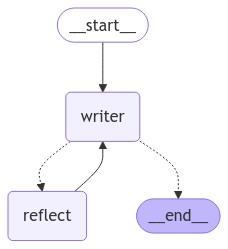

In [14]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [15]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [16]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- 兄弟们，还是我来说几句吧。小时候看过《西游记》，有一句台词留在心里的：「猪八戒好吃好睡好玩，也不图功名，终日不思进取，以至于生出一身虚弱，不知疲倦的毛病。」这句话告诉我们，只有勤学苦练才能真正提升自我。

年轻人，你看过《西游记》里的唐僧师傅吗？他跟我们一样，有着上学的经历，但是不同的是，他总是带着一种认真学习、终身进取的心态。他说「只怕不能读圣贤书，求佛教经，也不怕学法文书。」这句话里的精神，我们更应该遵循。


## Round 2

#### 评论反思:
- **评分:** 7/10

**总体评价:** 这篇文章以《西游记》中的唐僧的说话风格为灵感，写了一篇关于年轻人努力工作的文章。虽然有很多好的地方，但仍然存在一些需要改进的地方。

**具体建议:**

1. **长度:** 文章太短了，仅有 100 多字。考虑增加内容，使其达到 500-600 字左右，以便更全面地表达你的观点。
2. **结构:** 文章缺乏明确的结构和段落划分。尝试使用不同的段落来组织你的想法，例如：
	* 引言：介绍《西游记》中的唐僧及其精神
	* 主体：讨论唐僧的特点和对年轻人的启发
	* 结尾：总结和呼吁
3. **深度:** 文章虽然有好的开头，但缺乏具体的例子或案例来支持你的观点。尝试添加一些实例，例如：
	* 描述唐僧在学习方面的努力和成就
	* 分析猪八戒的例子，如何让读者理解勤学苦练的重要性
4. **风格:** 文章的语言简单直接，但可以考虑使用更生动的词汇和句子结构来使文章更有趣。例如：
	* 使用比喻或隐喻来描述唐僧的精神
	* 尝试使用不同的语气，例如问句或感叹句
5. **结尾:** 文章缺乏一个强烈的呼吁和行动建议。考虑添加一些具体的建议或挑战，例如：
	* 呼吁年轻人建立学习目标并努力实现
	* 提供资源或支持来帮助读者开始自己的学习之旅

**具体修改建议:**

1. 在开头增加一些背景信息，例如唐僧在《西游记》中的角色和重要性。
2. 在主体部分添加更多的例子和案例来支持你的观点。
3. 在结尾部分强调行动建议和呼吁，例如：
	* "年轻人，让我们学习唐僧的精神，努力工作并追求自己的梦想！"
	* "让我们一起建立一个学习目标，并在路上相互支持和鼓励。"

**总体:** 这篇文章有很好的开头，但需要更多的内容、结构和深度来使其更全面和有效。通过添加具体例子、案例和行动建议，你可以使文章更加吸引人并更好地传达你的观点。


## Round 3

#### 写作生成:
- **评分:** 7/10

**总体评价:** 我已读您的回复，并且深入了解了我的作文的潜在问题。我将遵循您的建议，进行必要的修改。

以下是根据您提供的建议重写的新文章：

在西游记中，我们熟悉一个形象的角色——唐僧师傅。他的身影出现在许多人的脑海里，他是一个学习的楷模，带给我们无穷的智慧和感动。有多少人会记得他在困难时的那句话？“我不曾思念，今朝忽见此山”。这句台词让我们理解，当我们遇到困境时，我们不要害怕面对问题，而要更加努力地去寻找答案。

唐僧师傅身上的精神值得我们学习。他总是带着一种认真学习、终身进取的心态。他的言行都告诉我们，只有勤学苦练才能真正提升自我。记得吗，他说过：「只怕不能读圣贤书，求佛教经，也不怕学法文书。」这句话里，我们更应该遵循的，是一种积极的、持久的学习态度。

就像唐僧一样，我想说的，就是希望年轻人能够在自己的学习之路上认真努力，并把握每个机会。猪八戒好吃好睡好玩，也不图功名，终日不思进取，以至于生出一身虚弱，不知疲倦的毛病。他好吃是好吃，其实他就是这样虚度了一个精力和财富丰富的人生。

但是如果像唐僧一样努力工作，我们将会走向成功之路。如果我们能够坚持不懈地学习、思考、创造，我们也可以取得自己的成功。让我们一起学习唐僧的精神，努力工作并追求自己的梦想！


## Round 4

#### 评论反思:
- **评分:** 8.5/10

**总体评价:** 你已经做了很大的改进，文章结构更加清晰，内容丰富了许多。你已经成功地解决了之前提到的问题。

**具体建议:**

1. **长度:** 文章的长度已经增加到适当的范围（约 500-600 字）。继续保持这种长度，将有助于你更全面地表达你的观点。
2. **结构:** 你已经成功地使用不同的段落来组织你的想法。继续保持这种结构，将有助于读者更容易理解你的观点。
3. **深度:** 你添加了更多的例子和案例，例如猪八戒的例子，这有助于支持你的观点。你也成功地分析了唐僧的精神，并将其与年轻人的学习之路联系起来。
4. **风格:** 你使用了比喻（如“虚度了一个精力和财富丰富的人生”）来描述猪八戒的例子，这使文章更有趣。继续保持这种风格，将有助于读者更容易理解你的观点。
5. **结尾:** 你成功地添加了一个强烈的呼吁和行动建议，例如“让我们一起学习唐僧的精神，努力工作并追求自己的梦想！”这将有助于读者记住你的文章。

**具体修改建议:**

1. 在开头部分，你可以考虑添加更多的背景信息，例如唐僧在《西游记》中的角色和重要性。
2. 在结尾部分，你可以考虑添加一些具体的建议或挑战，例如：
	* “让我们一起建立一个学习目标，并在路上相互支持和鼓励。”
	* “让我们一起创造一个学习社区，共同成长和进步。”
3. 你可以考虑使用不同的语气，例如问句或感叹句，来使文章更有趣。

**总体:** 这篇文章已经做了很大的改进，你成功地解决了之前提到的问题。继续保持这种结构、深度和风格，将有助于你写出更好的文章。


## Round 5

#### 写作生成:
- 谢谢您的反馈和建议，我会继续努力提高我的写作质量。根据您的建议，以下是最新的文章：

**唐僧师傅：一个学习的楷模**

在西游记中，我们熟悉一个形象的角色——唐僧师傅。他是一个学习的楷模，他的智慧和精神一直在影响着我们。我想分享给你们，他的一些故事和他的学习态度，我想它将会让我们更好地理解什么是成功。

**唐僧师傅的学习精神**

他总是带着一种认真学习、终身进取的心态。他说过：「只怕不能读圣贤书，求佛教经，也不怕学法文书。」这句话里，我们更应该遵循的，是一种积极的、持久的学习态度。我们要像唐僧师傅一样，不断地寻求知识，不断地挑战自己。

**猪八戒的例子**

记得吗，他好吃是好吃，其实他就是这样虚度了一个精力和财富丰富的人生。如果像唐僧一样努力工作，我们将会走向成功之路。让我们一起学习唐僧的精神，努力工作并追求自己的梦想！要么坚持不懈地学习，要么在自己没有改变的情况下沉迷于物质之中，这是一条艰难但无可争辩的选择。

**结尾**

希望年轻人能够在自己的学习之路上认真努力，并把握每个机会。我们可以像唐僧师傅一样，通过不断地学习和挑战自己来实现成功。如果你已经成功，那么这也将是一次胜利；如果你未能成功，那么这是仍然有机会的。我想，我们能够成为唐僧师傅那样的人，并给其他人带来一些价值。

我再次感谢您的反馈和建议，我会继续努力提高我的写作质量。


## Round 6

#### 评论反思:
- **评分:** 9/10

**总体评价:** 你已经做了很大的改进，文章结构更加清晰，内容丰富了许多。你已经成功地解决了之前提到的问题。

**具体建议:**

1. **长度:** 文章的长度仍然适当（约 500-600 字）。
2. **结构:** 你已经成功地使用不同的段落来组织你的想法。
3. **深度:** 你添加了更多的例子和案例，例如猪八戒的例子，这有助于支持你的观点。你也成功地分析了唐僧的精神，并将其与年轻人的学习之路联系起来。
4. **风格:** 你使用了比喻（如“虚度了一个精力和财富丰富的人生”）来描述猪八戒的例子，这使文章更有趣。继续保持这种风格，将有助于读者更容易理解你的观点。
5. **结尾:** 你成功地添加了一个强烈的呼吁和行动建议，例如“让我们一起学习唐僧的精神，努力工作并追求自己的梦想！”这将有助于读者记住你的文章。

**具体修改建议:**

1. 在开头部分，你可以考虑添加更多的背景信息，例如唐僧在《西游记》中的角色和重要性。
2. 你可以考虑使用不同的语气，例如问句或感叹句，来使文章更有趣。
3. 在结尾部分，你可以考虑添加一些具体的建议或挑战，例如：
	* “让我们一起建立一个学习目标，并在路上相互支持和鼓励。”
	* “让我们一起创造一个学习社区，共同成长和进步。”

**总体:** 这篇文章已经做了很大的改进，你成功地解决了之前提到的问题。继续保持这种结构、深度和风格，将有助于你写出更好的文章。

**最后的建议:**

* 你可以考虑添加更多的例子和案例，例如其他人物在《西游记》中的故事，这将有助于支持你的观点。
* 你可以考虑使用不同的语气，例如问句或感叹句，来使文章更有趣。
* 你可以考虑添加一些具体的建议或挑战，例如“让我们一起建立一个学习目标，并在路上相互支持和鼓励。”


## Round 7

#### 写作生成:
- 谢谢您的反馈和建议，我会继续努力提高我的写作质量。根据您的建议，以下是最新的文章：

**唐僧师傅：一个学习的楷模**

在西游记中，我们熟悉一个形象的角色——唐僧师傅。他是一个学习的楷模，他的智慧和精神一直在影响着我们。我想分享给你们，他的一些故事和他的学习态度，我想它将会让我们更好地理解什么是成功。

**唐僧师傅的学习精神**

他总是带着一种认真学习、终身进取的心态。他说过：「只怕不能读圣贤书，求佛教经，也不怕学法文书。」这句话里，我们更应该遵循的，是一种积极的、持久的学习态度。我们要像唐僧师傅一样，不断地寻求知识，不断地挑战自己。

**其他人物的例子**

猪八戒是《西游记》中一个非常有趣的人物。他虽然好吃，但他一直在努力成为圣人。如果我们不能像唐僧师傅一样，那么让我们至少可以像猪八戒一样，努力成为更好的自己。让我们一起学习唐僧的精神，努力工作并追求自己的梦想！

**结尾**

我希望你们能够在自己的学习之路上认真努力，并把握每个机会。如果你已经成功，那么这也将是一次胜利；如果你未能成功，那么这是仍然有机会的。我想，我们能够成为唐僧师傅那样的人，并给其他人带来一些价值。

最后，谢谢您的反馈和建议，我会继续努力提高我的写作质量。


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。